In [1]:
import pandas as pd
import numpy as np
import os, inspect
from RGCPD import RGCPD
from RGCPD import BivariateMI
import class_BivariateMI, functions_pp
from stat_models_cont import ScikitModel
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegressionCV
from data_preparations import coordinates, data_steps, mean, xarray
import func_models as fc_utils
from pipeline import pipeline

%load_ext autoreload
%autoreload 2

# main directory is the directory of this notebook
main_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) 

# my main directory (which contains folders with data etc)
my_main_dir = 'C:\\Users\\alicj\\Desktop\\WORK'
data_path = os.path.join(my_main_dir, 'data')

C:\Users\alicj\AppData\Local\Continuum\anaconda3\envs\RGCPD\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Not able to load in plotting modules, check installment of networkx


In [2]:
data_ond = pd.read_csv(os.path.join(data_path, 'OND.X1981_X2020.csv'))
data_ndj = pd.read_csv(os.path.join(data_path, 'NDJ.X1982_X2020.csv'))
data_djf = pd.read_csv(os.path.join(data_path, 'DJF.X1982_X2020.csv'))
data_jfm = pd.read_csv(os.path.join(data_path, 'JFM.X1981_X2020.csv'))

In [3]:
data_ond.columns = data_ond.columns.str.replace('[X]', '')
data_ndj.columns = data_ndj.columns.str.replace('[X]', '')
data_djf.columns = data_djf.columns.str.replace('[X]', '')
data_jfm.columns = data_jfm.columns.str.replace('[X]', '')

C:\Users\alicj\AppData\Local\Continuum\anaconda3\envs\RGCPD\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
C:\Users\alicj\AppData\Local\Continuum\anaconda3\envs\RGCPD\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\alicj\AppData\Local\Continuum\anaconda3\envs\RGCPD\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\alicj\AppData\Local\Continuum\anaconda3\envs\RGCPD\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [4]:
data_djf.head()

,V1,V2,1982,1983,1984,1985,1986,1987,1988,1989,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,30.225,-10.475,541,831,854,849,796,862,810,666,...,719,675,837,984,629,712,742,778,827,811
1,30.275,-10.475,560,843,877,836,813,876,826,673,...,717,660,848,989,647,712,758,779,833,828
2,30.325,-10.475,571,875,885,864,855,916,824,698,...,738,681,869,1029,665,740,778,807,853,853
3,30.375,-10.475,573,874,902,823,880,907,832,709,...,732,674,872,1027,674,739,789,808,849,862
4,30.425,-10.475,571,840,898,781,848,898,825,717,...,738,675,866,1019,672,730,782,795,841,851


# Prediction function to get AUC

prediction type is universally set to 'events' and the threshold value is set to 0.66

In [75]:
import func_models as fc_utils
from stat_models_cont import ScikitModel
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegressionCV


# choose type prediciton (continuous or probabilistic) by making comment #
#prediction = 'continuous'   
prediction = 'events' ; q = .66 # quantile threshold for event definition

def pred(rg, prediction = 'events', q = 0.66):
    if prediction == 'continuous':
        model = ScikitModel(Ridge, verbosity=0)
        # You can also tune parameters by passing a list of values. Then GridSearchCV from sklearn will 
        # find the set of parameters that give the best mean score on all kfold test sets. 
        # below we pass a list of alpha's to tune the regularization.
        alphas = list(np.concatenate([[1E-20],np.logspace(-5,0, 6), np.logspace(.01, 2.5, num=25)]))                       
        kwrgs_model = {'scoringCV':'neg_mean_absolute_error',
                       'kfold':5,
                       'alpha':alphas} # large a, strong regul.
    elif prediction == 'events':
        model = ScikitModel(LogisticRegressionCV, verbosity=0)
        kwrgs_model = {'kfold':5,
                       'scoring':'neg_brier_score'}

    target_ts = rg.TV.RV_ts ; 
    target_ts = (target_ts - target_ts.mean()) / target_ts.std()
    if prediction == 'events':
        if q >= 0.5:
            target_ts = (target_ts > target_ts.quantile(q)).astype(int)
        elif q < .5:
            target_ts = (target_ts < target_ts.quantile(q)).astype(int)
        BSS = fc_utils.ErrorSkillScore(constant_bench=float(target_ts.mean())).BSS
        score_func_list = [BSS, fc_utils.metrics.roc_auc_score]

    elif prediction == 'continuous':
        RMSE_SS = fc_utils.ErrorSkillScore(constant_bench=float(target_ts.mean())).RMSE
        MAE_SS = fc_utils.ErrorSkillScore(constant_bench=float(target_ts.mean())).MAE
        score_func_list = [RMSE_SS, fc_utils.corrcoef, MAE_SS]


    keys = [k for k in rg.df_data.columns[1:-2]]
    out = rg.fit_df_data_ridge(target=target_ts,
                                keys=keys, 
                                fcmodel=model,
                                kwrgs_model=kwrgs_model,
                                transformer=None,
                                tau_min=0, tau_max=0) # <- lag should be zero
    predict, weights, model_lags = out

    df_train_m, df_test_s_m, df_test_m, df_boot = fc_utils.get_scores(predict,
                                                                     rg.df_data.iloc[:,-2:],
                                                                     score_func_list,
                                                                     n_boot = 100, # bootstrapping for Conf. Intervals
                                                                     score_per_test=False,
                                                                     blocksize=1,
                                                                     rng_seed=1)
    if prediction == 'events':
        print(model.scikitmodel.__name__, '\n', f'Test score\n',
              'BSS {:.2f}\n'.format(df_test_m.loc[0].loc[0].loc['BSS']),
              'AUC {:.2f}'.format(df_test_m.loc[0].loc[0].loc['roc_auc_score']),
              '\nTrain score\n',
              'BSS {:.2f}\n'.format(df_train_m.mean(0).loc[0]['BSS']),
              'AUC {:.2f}'.format(df_train_m.mean(0).loc[0]['roc_auc_score']))
        auc_train = df_train_m.mean(0).loc[0]['roc_auc_score']
        auc_test = df_test_m.loc[0].loc[0].loc['roc_auc_score']
        bss_test = df_test_m.mean(0).loc[0]['BSS']
        return auc_test, bss_test
    elif prediction == 'continuous':
        print(model.scikitmodel.__name__, '\n', 'Test score\n',
              'RMSE {:.2f}\n'.format(df_test_m.loc[0][0]['RMSE']),
              'MAE {:.2f}\n'.format(df_test_m.loc[0][0]['MAE']),
              'corrcoef {:.2f}'.format(df_test_m.loc[0][0]['corrcoef']),
              '\nTrain score\n',
              'RMSE {:.2f}\n'.format(df_train_m.mean(0).loc[0]['RMSE']),
              'MAE {:.2f}\n'.format(df_train_m.mean(0).loc[0]['MAE']),
              'corrcoef {:.2f}'.format(df_train_m.mean(0).loc[0]['corrcoef']))

## Time handling

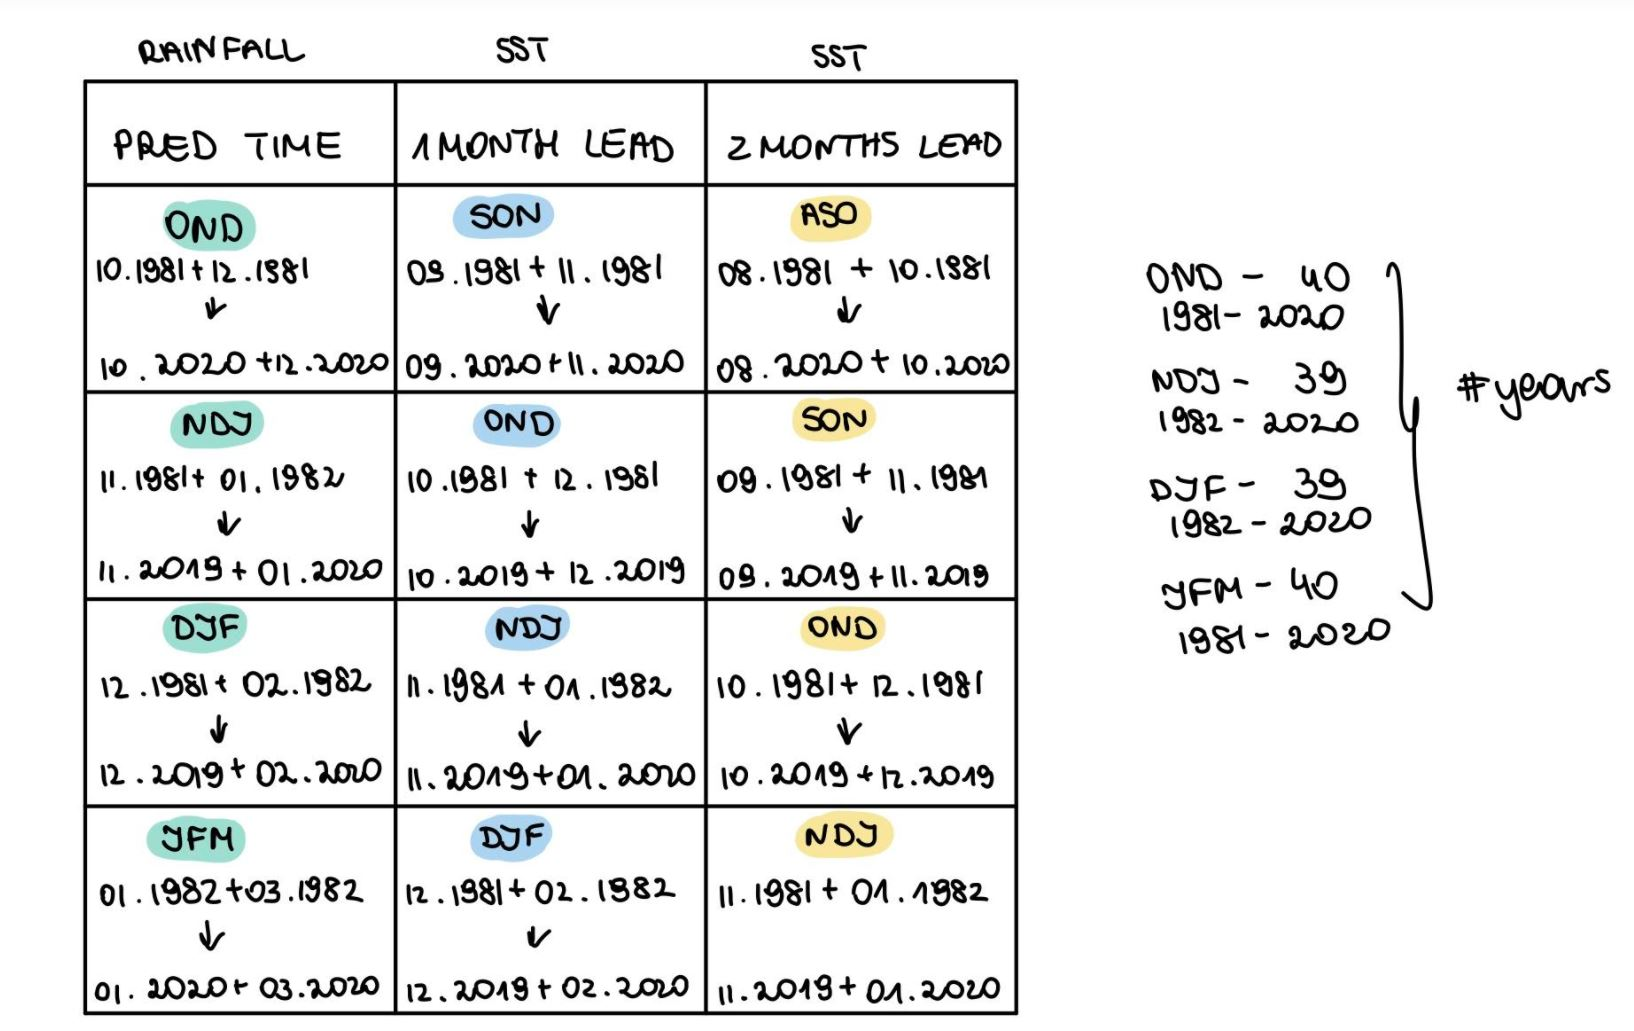

In [6]:
from IPython.display import Image
Image(filename = os.path.join(data_path, 'time.jpg'), width = 700, height = 1400)

OND 1981-2020, NDJ 1982-2020, DJF 1982-2020, JFM 1981-2020; year -> year of the last month, e.g. DJF 1982 means December 1981-February 1982

# define parameters that stay the same for all predictions

In [ ]:
function = class_BivariateMI.corr_map
alpha = 0.01
FDR_control = True 
distance_eps = 500
min_area_in_degrees2 = 5
tfreq = None

TVdates_aggr = False
ext_annual_to_mon = False 
method = 'leave_1'
detrend = True
labels = True
pred_type = 'continuous'
q = 0.6
name = 'rainfall'

# Tete predictions

### OND

In [7]:
tete_ond = coordinates(data_ond, [30.21215, 35.346607], [-17.70114, -13.9988])
tete_ond.head()

,V1,V2,1981,1982,1983,1984,1985,1986,1987,1988,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
14807,30.225,-14.025,135,242,241,309,277,299,245,205,...,245,258,314,220,230,291,346,248,185,354
14808,30.275,-14.025,135,244,243,303,274,301,246,206,...,244,258,317,219,226,294,351,254,191,360
14809,30.325,-14.025,132,223,226,321,274,314,229,207,...,248,243,305,220,223,274,362,258,192,357
14810,30.375,-14.025,135,222,226,327,269,308,224,217,...,248,240,304,218,226,275,380,265,198,361
14811,30.425,-14.025,135,228,215,322,272,310,228,219,...,253,239,305,212,221,267,389,266,199,359


In [8]:
# note that year-01-01 is just a naming convention, each entry contains aggregated value for OND per year
tete_ond_data = data_steps(tete_ond, 'rainfall') 
tete_ond_data.head()

,rainfall
index,
1981-01-01,199.479664
1982-01-01,234.457885
1983-01-01,217.502493
1984-01-01,325.231829
1985-01-01,373.997901


In [9]:
xarray(tete_ond_data).to_netcdf(os.path.join(data_path, 'tete_ond_aggr.nc'))

In [10]:
# directory of target variable data
TV_path = os.path.join(data_path, 'tete_ond_aggr.nc')

# directory of precursor data
prec_path = os.path.join(data_path,'sst_1950-2020_1_12_monthly_1.0deg.nc')

# directory for test data 
path_test = os.path.join(my_main_dir, 'test')

# directory for output
output_path = os.path.join(my_main_dir, 'out')

list_of_name_path = [(1, TV_path), ('sst', prec_path)]

## 1 month lead time (SON)

In [11]:
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)

lags = np.array([['09-01', '11-01']])            
periodnames = ['SON']                                         
start_end_TVdate = ('10-01', '12-01')    

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

[1981 2020] ('09-01', '11-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(39dp, 97%)

Plotting Corr maps sst, split 0, lag SON
Plotting Corr maps sst_labels_init, split 0, lag SON

Getting MI timeseries
There are [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] regions in total (list of different splits)


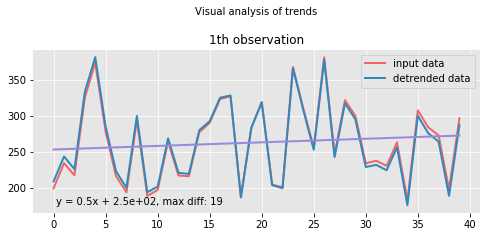

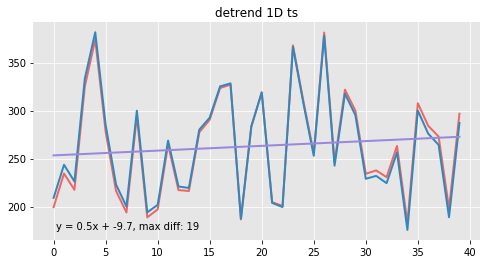

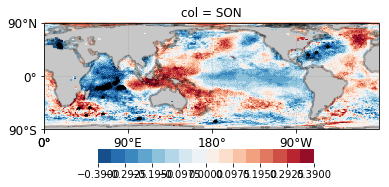

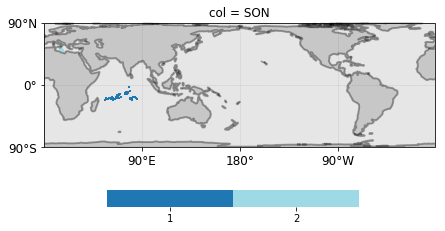

In [12]:
rg_tete_ond1 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)


## 2 months lead time (ASO)

In [13]:
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)

lags = np.array([['08-01', '10-01']])            
periodnames = ['ASO']                                         
start_end_TVdate = ('10-01', '12-01')    

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

[1981 2020] ('08-01', '10-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(39dp, 97%)

Plotting Corr maps sst, split 0, lag ASO
Plotting Corr maps sst_labels_init, split 0, lag ASO

Getting MI timeseries
There are [3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3] regions in total (list of different splits)


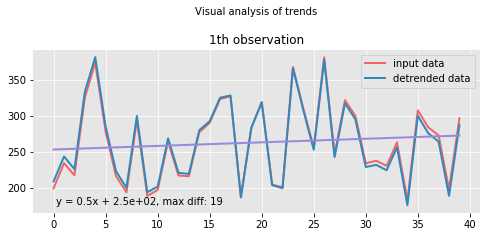

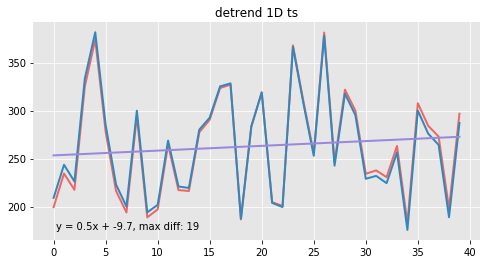

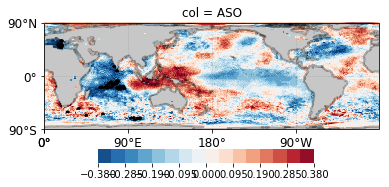

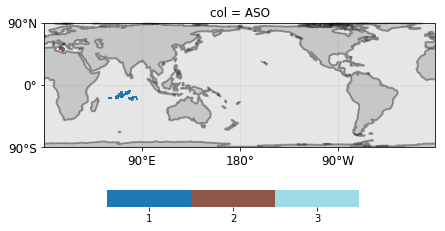

In [14]:
rg_tete_ond2 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)



## 3 months lead time (JAS)

In [ ]:
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)


lags = np.array([['07-01', '09-01']])            
periodnames = ['JAS']                                         
start_end_TVdate = ('10-01', '12-01')    

In [ ]:
rg_tete_ond3 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)



## 4 months lead time (JJA)

In [ ]:
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)


lags = np.array([['06-01', '08-01']])            
periodnames = ['JJA']                                         
start_end_TVdate = ('10-01', '12-01')    

In [ ]:
rg_tete_ond4 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)



## 5 months lead time (MJJ)

In [ ]:
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)


lags = np.array([['05-01', '07-01']])            
periodnames = ['MJJ']                                         
start_end_TVdate = ('10-01', '12-01')    

In [ ]:
rg_tete_ond5 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)



## 6 months lead time (AMJ)

In [ ]:
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)

lags = np.array([['04-01', '06-01']])            
periodnames = ['AMJ']                                         
start_end_TVdate = ('10-01', '12-01')    

In [ ]:
rg_tete_ond6 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)



### NDJ

In [15]:
tete_ndj = coordinates(data_ndj, [30.21215, 35.346607], [-17.70114, -13.9988])
tete_ndj.head()

,V1,V2,1982,1983,1984,1985,1986,1987,1988,1989,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
14807,30.225,-14.025,436,459,393,581,615,527,520,490,...,654,510,558,555,533,412,666,419,471,412
14808,30.275,-14.025,436,460,395,580,612,528,530,492,...,642,509,550,553,531,410,670,424,473,420
14809,30.325,-14.025,436,429,377,594,626,548,504,475,...,632,517,525,535,523,409,646,437,470,422
14810,30.375,-14.025,442,446,383,607,625,561,501,463,...,635,516,516,536,515,408,646,453,476,423
14811,30.425,-14.025,445,449,367,607,634,566,494,470,...,653,533,519,540,521,403,641,462,476,424


In [16]:
# note that year-01-01 is just a naming convention, each entry contains aggregated value for NDJ per year
tete_ndj_data = data_steps(tete_ndj, 'rainfall') 
tete_ndj_data.head()

,rainfall
index,
1982-01-01,421.366308
1983-01-01,346.583443
1984-01-01,320.506691
1985-01-01,580.628313
1986-01-01,635.651535


In [17]:
xarray(tete_ndj_data).to_netcdf(os.path.join(data_path, 'tete_ndj_aggr.nc'))

In [18]:
# directory of target variable data
TV_path = os.path.join(data_path, 'tete_ndj_aggr.nc')

# directory of precursor data
prec_path = os.path.join(data_path,'sst_1950-2020_1_12_monthly_1.0deg.nc')

# directory for test data 
path_test = os.path.join(my_main_dir, 'test')

# directory for output
output_path = os.path.join(my_main_dir, 'out')

list_of_name_path = [(1, TV_path), ('sst', prec_path)]

## 1 month lead time (OND)

In [19]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['10-01', '12-01']])            
periodnames = ['OND']                                         
start_end_TVdate = ('01-01', '11-01')    

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

[1981 2019] ('10-01', '12-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(38dp, 97%)

Plotting Corr maps sst, split 0, lag OND
Plotting Corr maps sst_labels_init, split 0, lag OND

Getting MI timeseries
There are [11, 9, 11, 11, 9, 11, 11, 11, 10, 11, 9, 11, 11, 9, 11, 11, 11, 8, 11, 11, 11, 10, 11, 11, 11, 11, 11, 11, 11, 9, 11, 11, 11, 11, 9, 11, 10, 11, 11] regions in total (list of different splits)


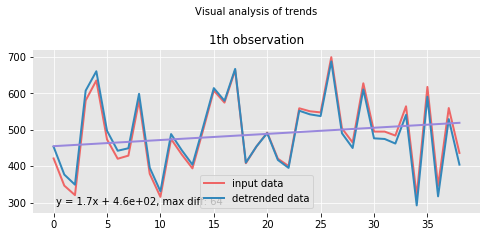

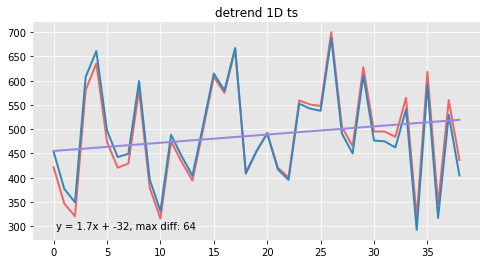

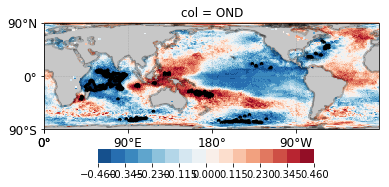

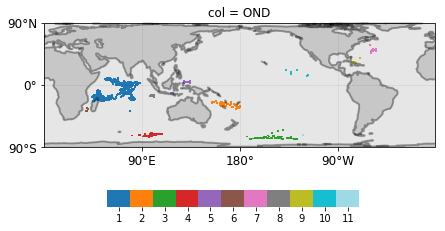

In [20]:
rg_tete_ndj1 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)



## 2 months lead time (SON)

In [21]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['09-01', '11-01']])            
periodnames = ['SON']                                         
start_end_TVdate = ('01-01', '11-01')    

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

[1981 2019] ('09-01', '11-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(38dp, 97%)

Plotting Corr maps sst, split 0, lag SON
Plotting Corr maps sst_labels_init, split 0, lag SON

Getting MI timeseries
There are [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 7, 8, 8, 8, 8, 7, 8, 8, 8, 8] regions in total (list of different splits)


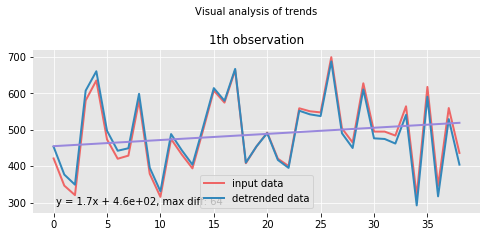

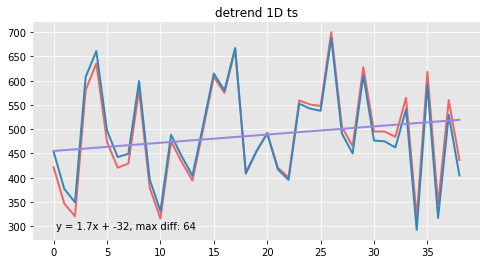

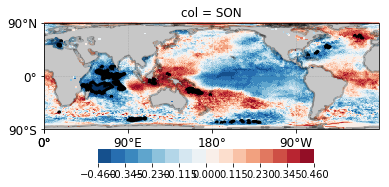

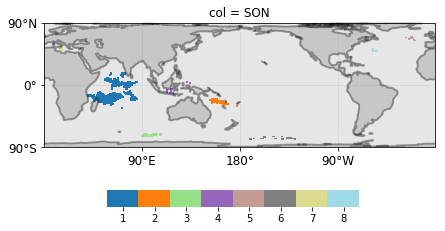

In [22]:
rg_tete_ndj2 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)



## 3 months lead time (ASO)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['08-01', '10-01']])            
periodnames = ['ASO']                                         
start_end_TVdate = ('01-01', '11-01')    

In [ ]:
rg_tete_ndj3 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)



## 4 months lead time (JAS)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['07-01', '09-01']])            
periodnames = ['JAS']                                         
start_end_TVdate = ('01-01', '11-01')    

In [ ]:
rg_tete_ndj4 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)



## 5 months lead time (JJA)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['06-01', '08-01']])            
periodnames = ['JJA']                                         
start_end_TVdate = ('01-01', '11-01')    

In [ ]:
rg_tete_ndj5 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)



## 6 months lead time (MJJ)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['05-01', '07-01']])            
periodnames = ['MJJ']                                         
start_end_TVdate = ('01-01', '11-01')    

In [ ]:
rg_tete_ndj6 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)



### DJF

In [23]:
tete_djf = coordinates(data_djf, [30.21215, 35.346607], [-17.70114, -13.9988])
tete_djf.head()

,V1,V2,1982,1983,1984,1985,1986,1987,1988,1989,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
14807,30.225,-14.025,690,542,562,763,720,550,735,758,...,645,601,703,682,700,457,896,550,600,562
14808,30.275,-14.025,695,544,566,757,711,550,745,758,...,624,600,694,686,706,458,912,546,606,582
14809,30.325,-14.025,695,511,553,737,726,567,733,715,...,618,605,651,660,689,468,888,578,606,585
14810,30.375,-14.025,706,553,573,757,739,586,736,684,...,619,610,638,658,681,470,893,577,610,590
14811,30.425,-14.025,702,539,563,754,755,589,730,695,...,632,627,641,659,690,474,893,602,622,592


In [24]:
# note that year-01-01 is just a naming convention, each entry contains aggregated value for DJF per year
tete_djf_data = data_steps(tete_djf, 'rainfall') 
tete_djf_data.head()

,rainfall
index,
1982-01-01,627.368276
1983-01-01,451.618342
1984-01-01,499.367358
1985-01-01,705.254526
1986-01-01,722.697980


In [25]:
xarray(tete_djf_data).to_netcdf(os.path.join(data_path, 'tete_djf_aggr.nc'))

In [26]:
# directory of target variable data
TV_path = os.path.join(data_path, 'tete_djf_aggr.nc')

# directory of precursor data
prec_path = os.path.join(data_path,'sst_1950-2020_1_12_monthly_1.0deg.nc')

# directory for test data 
path_test = os.path.join(my_main_dir, 'test')

# directory for output
output_path = os.path.join(my_main_dir, 'out')

list_of_name_path = [(1, TV_path), ('sst', prec_path)]

## 1 month lead time (NDJ)

In [27]:
start_end_year = (1981, 2020)
start_end_TVyear = (1982, 2020)

lags = np.array([['11-01', '01-01']])            
periodnames = ['NDJ']                                         
start_end_TVdate = ('02-01', '12-01')    

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

[1981 2020] ('11-01', '01-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(38dp, 97%)

Plotting Corr maps sst, split 0, lag NDJ
Plotting Corr maps sst_labels_init, split 0, lag NDJ

Getting MI timeseries
There are [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 9, 9, 9, 9, 9, 9, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9] regions in total (list of different splits)


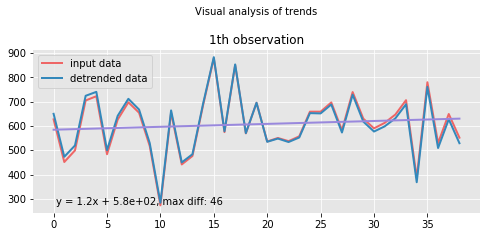

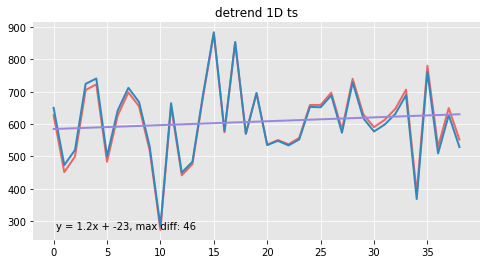

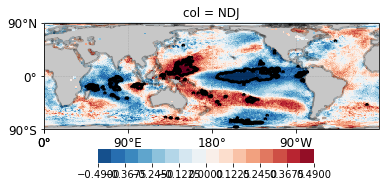

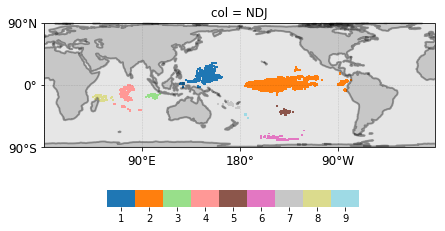

In [28]:
rg_tete_djf1 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)


## 2 months lead time (OND)

In [29]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['10-01', '12-01']])            
periodnames = ['OND']                                         
start_end_TVdate = ('02-01', '12-01')    

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

[1981 2019] ('09-01', '11-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(38dp, 97%)

Plotting Corr maps sst, split 0, lag OND
Plotting Corr maps sst_labels_init, split 0, lag OND

Getting MI timeseries
There are [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8] regions in total (list of different splits)


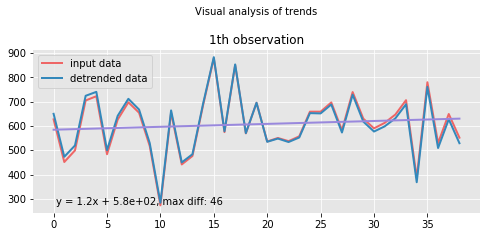

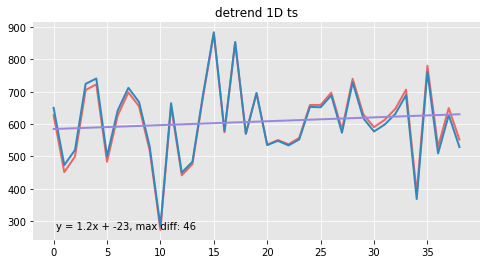

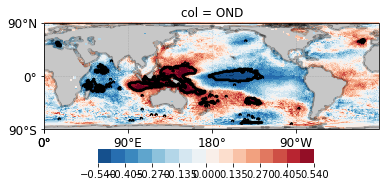

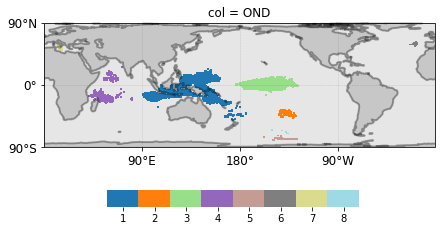

In [30]:
rg_tete_djf2 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)


## 3 months lead time (SON)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['09-01', '11-01']])            
periodnames = ['SON']                                         
start_end_TVdate = ('02-01', '12-01')    

In [ ]:
rg_tete_djf3 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)


## 4 month lead time (ASO)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['08-01', '10-01']])            
periodnames = ['ASO']                                         
start_end_TVdate = ('02-01', '12-01')    

In [ ]:
rg_tete_djf4 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)


## 5 month lead time (JAS)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)


lags = np.array([['07-01', '09-01']])            
periodnames = ['JAS']                                         
start_end_TVdate = ('02-01', '12-01')    

In [ ]:
rg_tete_djf5 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)


## 6 month lead time (JJA)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['06-01', '08-01']])            
periodnames = ['JJA']                                         
start_end_TVdate = ('02-01', '12-01')    

In [ ]:
rg_tete_djf6 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)


### JFM

In [31]:
tete_jfm = coordinates(data_jfm, [30.21215, 35.346607], [-17.70114, -13.9988])
tete_jfm.head()

,V1,V2,1981,1982,1983,1984,1985,1986,1987,1988,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
14807,30.225,-14.025,527,636,473,493,619,611,421,701,...,452,594,543,537,584,466,794,457,466,504
14808,30.275,-14.025,523,640,474,490,613,606,419,709,...,439,598,534,534,591,449,805,448,462,520
14809,30.325,-14.025,518,641,447,488,584,631,413,721,...,431,595,500,515,571,439,793,492,452,520
14810,30.375,-14.025,520,648,483,528,589,664,421,750,...,440,596,494,518,564,438,799,485,455,522
14811,30.425,-14.025,530,650,470,525,594,685,424,742,...,448,618,501,518,582,461,810,508,471,524


In [32]:
# note that year-01-01 is just a naming convention, each entry contains aggregated value for JFM per year
tete_jfm_data = data_steps(tete_jfm, 'rainfall') 
tete_jfm_data.head()

,rainfall
index,
1981-01-01,549.967069
1982-01-01,550.434532
1983-01-01,377.101023
1984-01-01,457.554972
1985-01-01,647.911834


In [33]:
xarray(tete_jfm_data).to_netcdf(os.path.join(data_path, 'tete_jfm_aggr.nc'))

In [34]:
# directory of target variable data
TV_path = os.path.join(data_path, 'tete_jfm_aggr.nc')

# directory of precursor data
prec_path = os.path.join(data_path,'sst_1950-2020_1_12_monthly_1.0deg.nc')

# directory for test data 
path_test = os.path.join(my_main_dir, 'test')

# directory for output
output_path = os.path.join(my_main_dir, 'out')

list_of_name_path = [(1, TV_path), ('sst', prec_path)]

### 1 month lead time (DJF)

In [35]:
start_end_year = (1981, 2020)
start_end_TVyear = (1982, 2020)

lags = np.array([['12-01', '02-01']])            
periodnames = ['DJF']                                         
start_end_TVdate = ('01-01', '03-01')    

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

[1981 2020] ('12-01', '02-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(38dp, 97%)

Plotting Corr maps sst, split 0, lag DJF
Plotting Corr maps sst_labels_init, split 0, lag DJF

Getting MI timeseries
There are [8, 7, 7, 8, 8, 7, 8, 7, 8, 8, 5, 8, 8, 7, 8, 7, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8] regions in total (list of different splits)


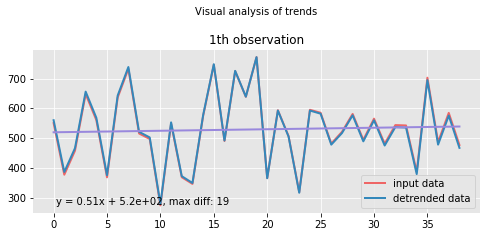

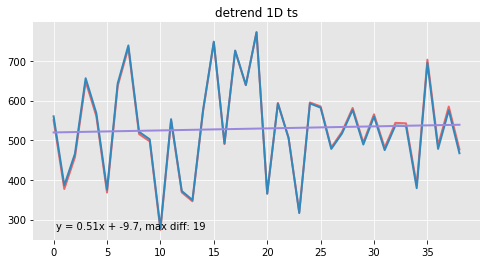

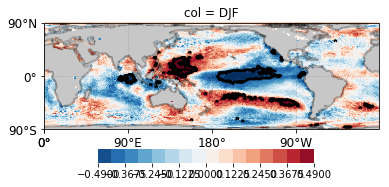

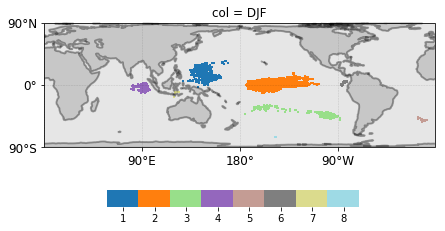

In [36]:
rg_tete_jfm1 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)


### 2 months lead time (NDJ)

In [37]:
start_end_year = (1981, 2020)
start_end_TVyear = (1982, 2020)

lags = np.array([['11-01', '01-01']])            
periodnames = ['NDJ']                                         
start_end_TVdate = ('01-01', '03-01')    

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

[1981 2020] ('11-01', '01-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(38dp, 97%)

Plotting Corr maps sst, split 0, lag NDJ
Plotting Corr maps sst_labels_init, split 0, lag NDJ

Getting MI timeseries
There are [11, 10, 11, 10, 11, 10, 11, 11, 11, 11, 8, 11, 10, 9, 11, 10, 11, 7, 11, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 9, 11, 11, 11, 11] regions in total (list of different splits)


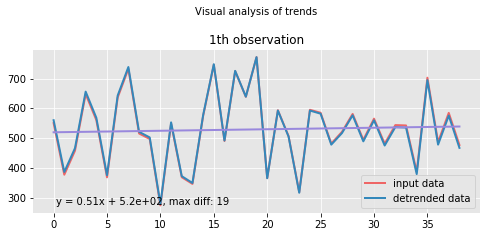

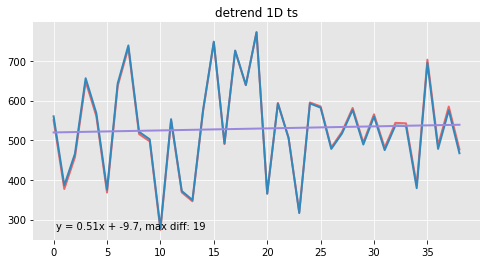

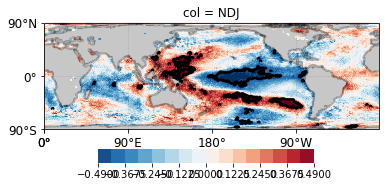

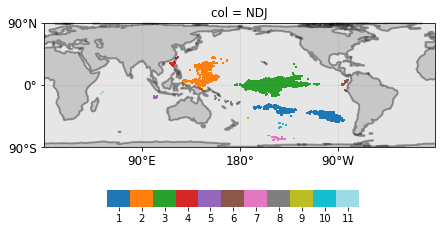

In [38]:
rg_tete_jfm2 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)


## 3 months lead time (OND)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['10-01', '12-01']])            
periodnames = ['OND']                                         
start_end_TVdate = ('01-01', '03-01')    

In [ ]:
rg_tete_jfm3 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)


## 4 months lead time (SON)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['09-01', '11-01']])            
periodnames = ['SON']                                         
start_end_TVdate = ('01-01', '03-01')    

In [ ]:
rg_tete_jfm4 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)


## 5 months lead time (ASO)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['08-01', '10-01']])            
periodnames = ['ASO']                                         
start_end_TVdate = ('01-01', '03-01')    

In [ ]:
rg_tete_jfm5 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)


## 6 months lead time (JAS)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['07-01', '09-01']])            
periodnames = ['JAS']                                         
start_end_TVdate = ('01-01', '03-01')    

In [ ]:
rg_tete_jfm6 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)


# Gaza predictions

### OND

In [40]:
gaza_ond = coordinates(data_ond, [31.30631, 34.47342], [-25.38095, -21.30902])
gaza_ond.head()

,V1,V2,1981,1982,1983,1984,1985,1986,1987,1988,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
37264,31.325,-21.325,176,121,165,312,195,142,305,106,...,235,104,191,183,80,295,183,109,146,258
37265,31.375,-21.325,168,119,161,288,181,134,282,97,...,222,98,179,175,80,280,166,104,132,239
37266,31.425,-21.325,159,111,150,273,195,153,249,98,...,213,96,168,168,79,266,154,105,128,227
37267,31.475,-21.325,150,108,134,259,187,142,255,109,...,206,89,156,163,75,251,136,95,117,220
37268,31.525,-21.325,169,108,134,258,187,143,256,111,...,208,93,157,166,77,251,133,101,117,219


In [41]:
# note that year-01-01 is just a naming convention, each entry contains aggregated value for OND per year
gaza_ond_data = data_steps(gaza_ond, 'rainfall') 
gaza_ond_data.head()

,rainfall
index,
1981-01-01,221.933929
1982-01-01,131.531746
1983-01-01,182.690079
1984-01-01,230.486706
1985-01-01,217.497421


In [42]:
xarray(gaza_ond_data).to_netcdf(os.path.join(data_path, 'gaza_ond_aggr.nc'))

In [43]:
# directory of target variable data
TV_path = os.path.join(data_path, 'gaza_ond_aggr.nc')

# directory of precursor data
prec_path = os.path.join(data_path,'sst_1950-2020_1_12_monthly_1.0deg.nc')

# directory for test data 
path_test = os.path.join(my_main_dir, 'test')

# directory for output
output_path = os.path.join(my_main_dir, 'out')

list_of_name_path = [(1, TV_path), ('sst', prec_path)]

### 1 month lead time

In [44]:
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)

lags = np.array([['09-01', '11-01']])            
periodnames = ['SON']                                         
start_end_TVdate = ('10-01', '12-01')    

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

[1981 2020] ('09-01', '11-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(39dp, 97%)

Plotting Corr maps sst, split 0, lag SON
Plotting Corr maps sst_labels_init, split 0, lag SON

Getting MI timeseries
There are [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9] regions in total (list of different splits)


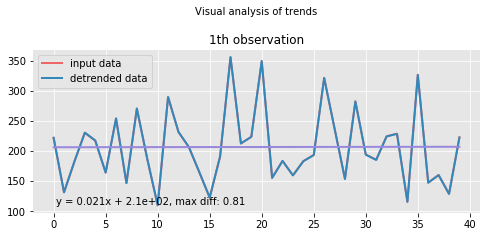

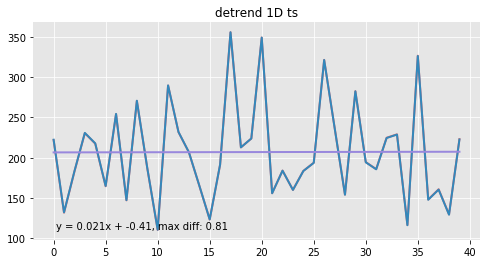

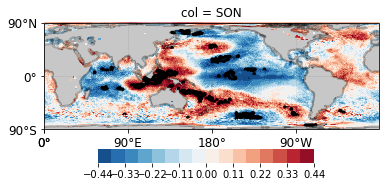

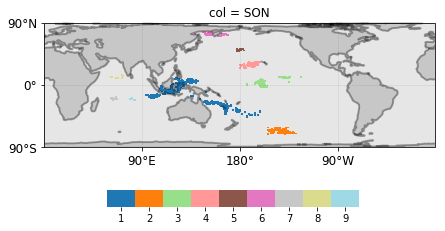

In [45]:
rg_gaza_ond1 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 2 months lead time

In [46]:
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)

lags = np.array([['08-01', '10-01']])            
periodnames = ['ASO']                                         
start_end_TVdate = ('10-01', '12-01')    

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

[1981 2020] ('08-01', '10-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(39dp, 97%)

Plotting Corr maps sst, split 0, lag ASO
Plotting Corr maps sst_labels_init, split 0, lag ASO

Getting MI timeseries
There are [11, 9, 11, 11, 10, 10, 11, 10, 11, 10, 10, 11, 11, 10, 10, 10, 10, 5, 11, 10, 9, 10, 10, 10, 10, 10, 9, 10, 11, 8, 11, 11, 10, 11, 8, 9, 10, 11, 10, 11] regions in total (list of different splits)


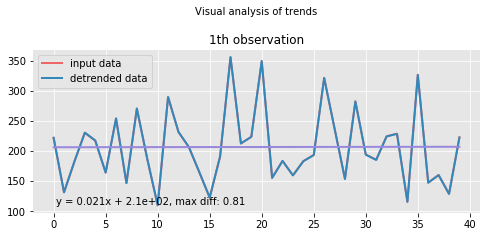

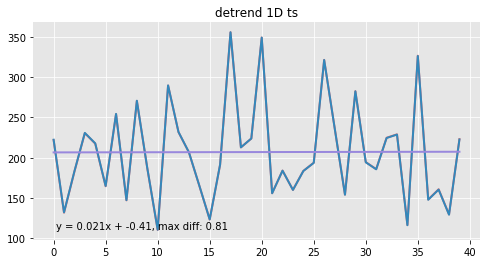

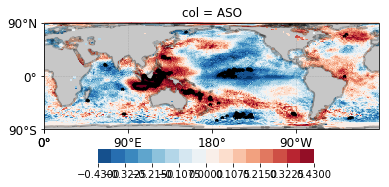

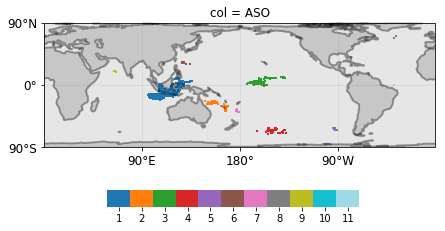

In [47]:
rg_gaza_ond2 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 3 months lead time (JAS)

In [ ]:
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)

lags = np.array([['07-01', '09-01']])            
periodnames = ['JAS']                                         
start_end_TVdate = ('10-01', '12-01')    

In [ ]:
rg_gaza_ond3 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 4 months lead time (JJA)

In [ ]:
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)


lags = np.array([['06-01', '08-01']])            
periodnames = ['JJA']                                         
start_end_TVdate = ('10-01', '12-01') 

In [ ]:
rg_gaza_ond4 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 5 months lead time (MJJ)

In [ ]:
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)


lags = np.array([['05-01', '07-01']])            
periodnames = ['MJJ']                                         
start_end_TVdate = ('10-01', '12-01') 

In [ ]:
rg_gaza_ond5 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 6 months lead time (AMJ)

In [ ]:
start_end_year = (1981, 2020)
start_end_TVyear = (1981, 2020)

lags = np.array([['04-01', '06-01']])            
periodnames = ['AMJ']                                         
start_end_TVdate = ('10-01', '12-01')

In [ ]:
rg_gaza_ond6 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### NDJ

In [48]:
gaza_ndj = coordinates(data_ndj, [31.30631, 34.47342], [-25.38095, -21.30902])
gaza_ndj.head()

,V1,V2,1982,1983,1984,1985,1986,1987,1988,1989,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
37264,31.325,-21.325,193,122,220,448,234,179,325,112,...,570,266,324,328,231,145,572,147,196,275
37265,31.375,-21.325,181,113,209,407,214,158,298,100,...,516,250,298,310,215,139,534,133,178,247
37266,31.425,-21.325,162,109,174,360,229,154,257,90,...,427,230,244,268,193,125,452,118,151,208
37267,31.475,-21.325,146,99,144,314,206,136,259,95,...,367,216,191,223,176,106,370,107,123,168
37268,31.525,-21.325,164,100,142,306,203,138,257,97,...,357,218,182,217,179,105,359,102,127,164


In [49]:
# note that year-01-01 is just a naming convention, each entry contains aggregated value for NDJ per year
gaza_ndj_data = data_steps(gaza_ndj, 'rainfall') 
gaza_ndj_data.head()

,rainfall
index,
1982-01-01,218.691667
1983-01-01,149.930159
1984-01-01,303.830754
1985-01-01,360.585913
1986-01-01,271.030357


In [50]:
xarray(gaza_ndj_data).to_netcdf(os.path.join(data_path, 'gaza_ndj_aggr.nc'))

In [51]:
# directory of target variable data
TV_path = os.path.join(data_path, 'gaza_ndj_aggr.nc')

# directory of precursor data
prec_path = os.path.join(data_path,'sst_1950-2020_1_12_monthly_1.0deg.nc')

# directory for test data 
path_test = os.path.join(my_main_dir, 'test')

# directory for output
output_path = os.path.join(my_main_dir, 'out')

list_of_name_path = [(1, TV_path), ('sst', prec_path)]

### 1 month lead time (OND)

In [52]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)


lags = np.array([['10-01', '12-01']])            
periodnames = ['OND']                                         
start_end_TVdate = ('01-01', '11-01')    

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

[1981 2019] ('10-01', '12-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(38dp, 97%)

Plotting Corr maps sst, split 0, lag OND
Plotting Corr maps sst_labels_init, split 0, lag OND

Getting MI timeseries
There are [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 12, 12, 12, 11, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 12, 11, 12, 12, 12] regions in total (list of different splits)


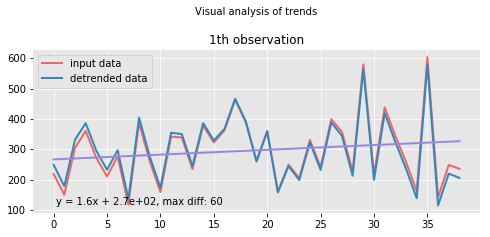

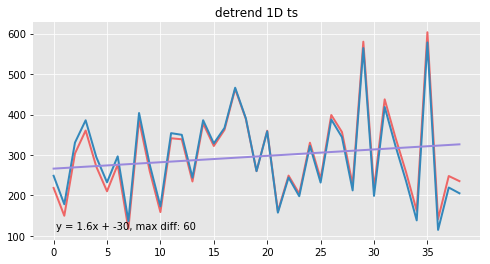

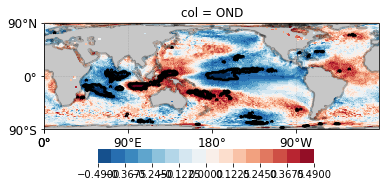

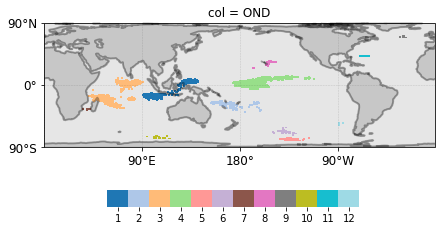

In [53]:
rg_gaza_ndj1 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 2 months lead time (SON)

In [54]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['09-01', '11-01']])            
periodnames = ['SON']                                         
start_end_TVdate = ('01-01', '11-01')  

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

[1981 2019] ('09-01', '11-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(38dp, 97%)

Plotting Corr maps sst, split 0, lag SON
Plotting Corr maps sst_labels_init, split 0, lag SON

Getting MI timeseries
There are [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 11, 11, 11] regions in total (list of different splits)


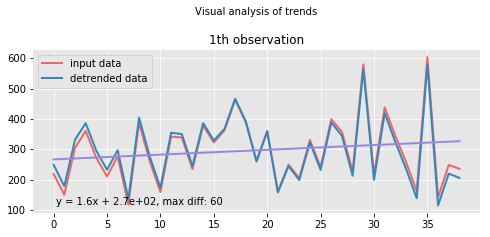

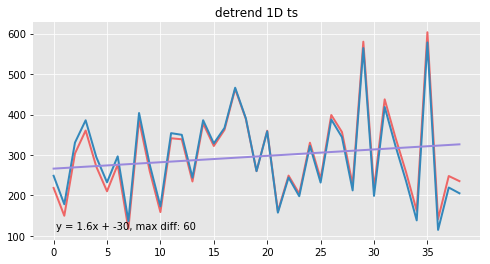

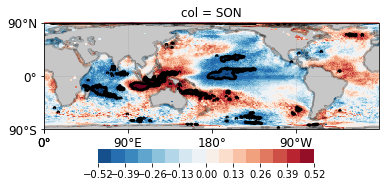

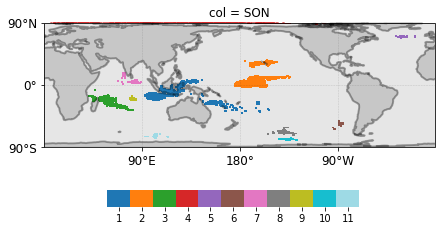

In [55]:
rg_gaza_ndj2 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 3 months lead time (ASO)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['08-01', '10-01']])            
periodnames = ['ASO']                                         
start_end_TVdate = ('01-01', '11-01')    

In [ ]:
rg_gaza_ndj3 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 4 months lead time (JAS)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['07-01', '09-01']])            
periodnames = ['JAS']                                         
start_end_TVdate = ('01-01', '11-01')

In [ ]:
rg_gaza_ndj4 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 5 months lead time (JJA)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['06-01', '08-01']])            
periodnames = ['JJA']                                         
start_end_TVdate = ('01-01', '11-01')   

In [ ]:
rg_gaza_ndj5 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 6 months lead time (MJJ)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['05-01', '07-01']])            
periodnames = ['MJJ']                                         
start_end_TVdate = ('01-01', '11-01')  

In [ ]:
rg_gaza_ndj6 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### DJF

In [56]:
gaza_djf = coordinates(data_djf, [31.30631, 34.47342], [-25.38095, -21.30902])
gaza_djf.head()

,V1,V2,1982,1983,1984,1985,1986,1987,1988,1989,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
37264,31.325,-21.325,184,132,216,450,221,235,391,174,...,522,224,316,370,230,125,720,394,271,360
37265,31.375,-21.325,165,121,201,401,195,206,342,152,...,470,204,288,344,208,117,671,336,244,319
37266,31.425,-21.325,121,103,161,335,181,175,254,112,...,379,177,230,280,170,94,521,241,182,241
37267,31.475,-21.325,98,90,127,270,155,142,248,105,...,320,157,175,219,149,75,399,185,143,176
37268,31.525,-21.325,94,92,125,260,154,139,245,101,...,310,157,166,212,146,71,385,182,147,169


In [57]:
# note that year-01-01 is just a naming convention, each entry contains aggregated value for DJF per year
gaza_djf_data = data_steps(gaza_djf, 'rainfall') 
gaza_djf_data.head()

,rainfall
index,
1982-01-01,240.440278
1983-01-01,182.785317
1984-01-01,302.030952
1985-01-01,406.112897
1986-01-01,251.088095


In [58]:
xarray(gaza_djf_data).to_netcdf(os.path.join(data_path, 'gaza_djf_aggr.nc'))

In [59]:
# directory of target variable data
TV_path = os.path.join(data_path, 'gaza_djf_aggr.nc')

# directory of precursor data
prec_path = os.path.join(data_path,'sst_1950-2020_1_12_monthly_1.0deg.nc')

# directory for test data 
path_test = os.path.join(my_main_dir, 'test')

# directory for output
output_path = os.path.join(my_main_dir, 'out')

list_of_name_path = [(1, TV_path), ('sst', prec_path)]

### 1 month lead time (NDJ)

In [60]:
start_end_year = (1981, 2020)
start_end_TVyear = (1982, 2020)

lags = np.array([['11-01', '01-01']])            
periodnames = ['NDJ']                                         
start_end_TVdate = ('02-01', '12-01')   

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

[1981 2020] ('11-01', '01-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(38dp, 97%)

Plotting Corr maps sst, split 0, lag NDJ
Plotting Corr maps sst_labels_init, split 0, lag NDJ

Getting MI timeseries
There are [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 11, 11, 11, 11, 11, 11, 7, 9, 11, 11, 11, 11, 11, 11, 11, 11, 11, 9, 11, 11, 11, 11, 11, 10, 9, 11, 11, 11] regions in total (list of different splits)


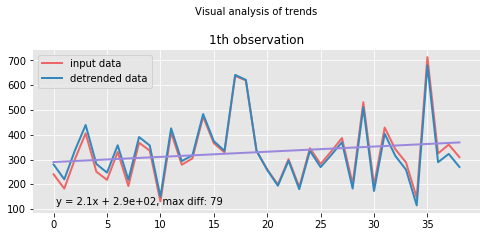

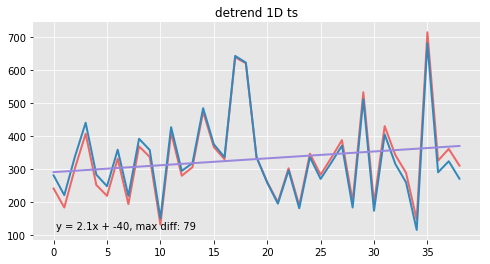

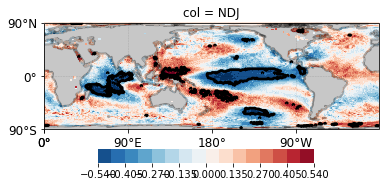

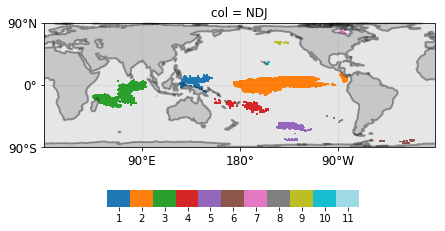

In [61]:
rg_gaza_djf1 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 2 months lead time (OND)

In [62]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['09-01', '11-01']])            
periodnames = ['OND']                                         
start_end_TVdate = ('02-01', '12-01')    

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

[1981 2019] ('09-01', '11-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(38dp, 97%)

Plotting Corr maps sst, split 0, lag OND
Plotting Corr maps sst_labels_init, split 0, lag OND

Getting MI timeseries
There are [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 9, 9, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12] regions in total (list of different splits)


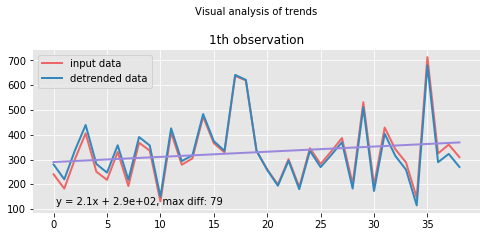

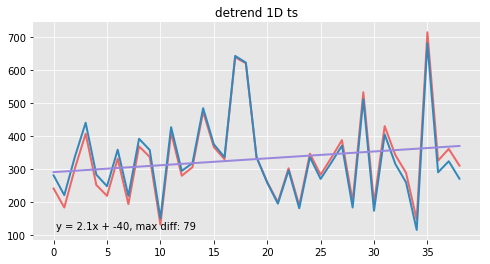

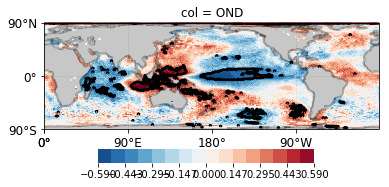

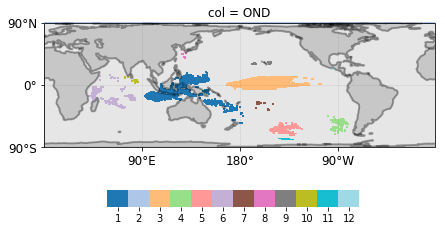

In [63]:
rg_gaza_djf2 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 3 months lead time (SON)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['09-01', '11-01']])            
periodnames = ['SON']                                         
start_end_TVdate = ('02-01', '12-01')  

In [ ]:
rg_gaza_djf3 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 4 months lead time (ASO)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['08-01', '10-01']])            
periodnames = ['ASO']                                         
start_end_TVdate = ('02-01', '12-01') 

In [ ]:
rg_gaza_djf4 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 5 months lead time (JAS)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)


lags = np.array([['07-01', '09-01']])            
periodnames = ['JAS']                                         
start_end_TVdate = ('02-01', '12-01') 

In [ ]:
rg_gaza_djf5 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 6 months lead time (JJA)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['06-01', '08-01']])            
periodnames = ['JJA']                                         
start_end_TVdate = ('02-01', '12-01')    

In [ ]:
rg_gaza_djf6 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### JFM

In [64]:
gaza_jfm = coordinates(data_jfm, [31.30631, 34.47342], [-25.38095, -21.30902])
gaza_jfm.head()

,V1,V2,1981,1982,1983,1984,1985,1986,1987,1988,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
37264,31.325,-21.325,321,174,128,263,369,189,184,268,...,320,125,302,399,174,272,571,393,227,308
37265,31.375,-21.325,288,157,116,236,324,169,159,226,...,286,119,275,377,148,247,524,333,204,275
37266,31.425,-21.325,203,109,84,162,233,121,102,141,...,206,83,206,275,100,179,364,228,137,194
37267,31.475,-21.325,146,90,51,109,164,86,70,98,...,146,59,149,189,69,124,244,164,97,130
37268,31.525,-21.325,145,85,48,92,148,78,64,83,...,127,54,135,170,59,99,226,158,97,124


In [65]:
# note that year-01-01 is just a naming convention, each entry contains aggregated value for JFM per year
gaza_jfm_data = data_steps(gaza_jfm, 'rainfall') 
gaza_jfm_data.head()

,rainfall
index,
1981-01-01,374.074603
1982-01-01,206.517460
1983-01-01,171.523016
1984-01-01,304.486310
1985-01-01,372.125992


In [66]:
xarray(gaza_jfm_data).to_netcdf(os.path.join(data_path, 'gaza_jfm_aggr.nc'))

In [67]:
# directory of target variable data
TV_path = os.path.join(data_path, 'gaza_jfm_aggr.nc')

# directory of precursor data
prec_path = os.path.join(data_path,'sst_1950-2020_1_12_monthly_1.0deg.nc')

# directory for test data 
path_test = os.path.join(my_main_dir, 'test')

# directory for output
output_path = os.path.join(my_main_dir, 'out')

list_of_name_path = [(1, TV_path), ('sst', prec_path)]

### 1 month lead time (DJF)

In [68]:
start_end_year = (1981, 2020)
start_end_TVyear = (1982, 2020)

lags = np.array([['12-01', '02-01']])            
periodnames = ['DJF']                                         
start_end_TVdate = ('01-01', '03-01')  

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

[1981 2020] ('12-01', '02-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(38dp, 97%)

Plotting Corr maps sst, split 0, lag DJF
Plotting Corr maps sst_labels_init, split 0, lag DJF

Getting MI timeseries
There are [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5] regions in total (list of different splits)


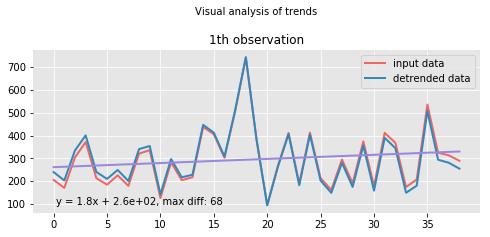

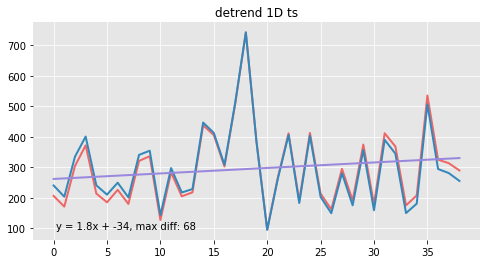

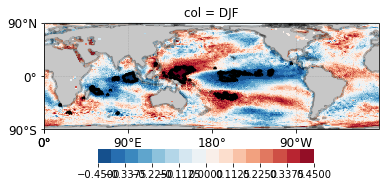

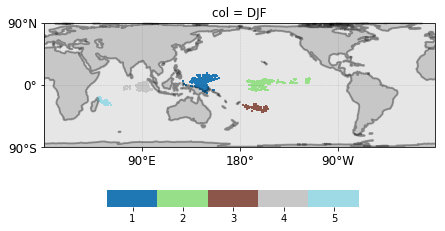

In [69]:
rg_gaza_jfm1 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 2 months lead time (NDJ)

In [70]:
start_end_year = (1981, 2020)
start_end_TVyear = (1982, 2020)

lags = np.array([['11-01', '01-01']])            
periodnames = ['NDJ']                                         
start_end_TVdate = ('01-01', '03-01')    

Start linear detrending ...
Done
Visual test on 0th observationDetected timeseries with annual mean values
tfreq is None, no common time aggregation used, loading annual mean data
Loaded pre-processed data of sst

[1981 2020] ('11-01', '01-01')

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(38dp, 97%)

Plotting Corr maps sst, split 0, lag NDJ
Plotting Corr maps sst_labels_init, split 0, lag NDJ

Getting MI timeseries
There are [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 8, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 8, 9, 9, 9] regions in total (list of different splits)


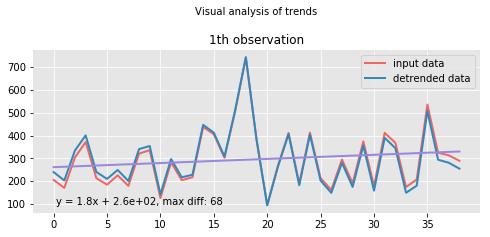

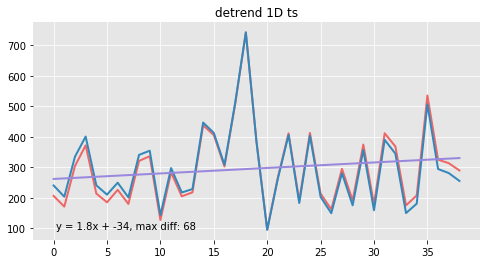

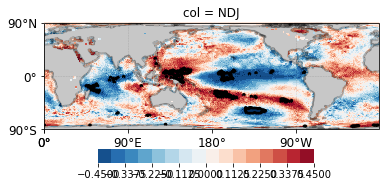

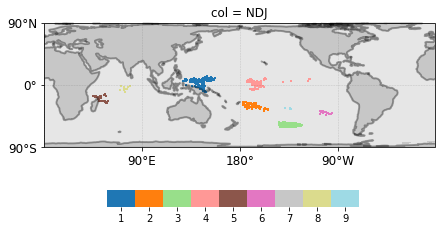

In [71]:
rg_gaza_jfm2 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 3 months lead time (OND)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['10-01', '12-01']])            
periodnames = ['OND']                                         
start_end_TVdate = ('01-01', '03-01')  

In [ ]:
rg_gaza_jfm3 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 4 months lead time (SON)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['09-01', '11-01']])            
periodnames = ['SON']                                         
start_end_TVdate = ('01-01', '03-01') 

In [ ]:
rg_gaza_jfm4 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 5 months lead time (ASO)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['08-01', '10-01']])            
periodnames = ['ASO']                                         
start_end_TVdate = ('01-01', '03-01') 

In [ ]:
rg_gaza_jfm5 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

### 6 months lead time (JAS)

In [ ]:
start_end_year = (1981, 2019)
start_end_TVyear = (1982, 2020)

lags = np.array([['07-01', '09-01']])            
periodnames = ['JAS']                                         
start_end_TVdate = ('01-01', '03-01')  

In [ ]:
rg_gaza_jfm6 = pipeline(list_of_name_path, output_path, function, alpha, FDR_control, distance_eps, min_area_in_degrees2, tfreq, start_end_year, 
             start_end_TVyear, TVdates_aggr, ext_annual_to_mon, method, detrend, labels, pred_type, q, lags, periodnames, start_end_TVdate, name)

## Calculating AUC's & BSS

## TETE

### Tete 1 month lead time 

In [76]:
auc_rg_tete_ond1, bss_rg_tete_ond1 = pred(rg_tete_ond1)

LogisticRegressionCV 
 Test score
 BSS 0.07
 AUC 0.67 
Train score
 BSS 0.27
 AUC 0.82


In [77]:
auc_rg_tete_ndj1, bss_rg_tete_ndj1 = pred(rg_tete_ndj1)

C:\Users\alicj\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\alicj\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

LogisticRegressionCV 
 Test score
 BSS -0.02
 AUC 0.67 
Train score
 BSS 0.39
 AUC 0.89


In [78]:
auc_rg_tete_djf1, bss_rg_tete_djf1 = pred(rg_tete_djf1)

LogisticRegressionCV 
 Test score
 BSS 0.02
 AUC 0.65 
Train score
 BSS 0.28
 AUC 0.85


In [79]:
auc_rg_tete_jfm1, bss_rg_tete_jfm1 = pred(rg_tete_jfm1)

LogisticRegressionCV 
 Test score
 BSS -0.18
 AUC 0.53 
Train score
 BSS 0.34
 AUC 0.84


### Tete 2 month lead time

In [80]:
auc_rg_tete_ond2, bss_rg_tete_ond2 = pred(rg_tete_ond2)

LogisticRegressionCV 
 Test score
 BSS 0.08
 AUC 0.67 
Train score
 BSS 0.28
 AUC 0.81


In [81]:
auc_rg_tete_ndj2, bss_rg_tete_ndj2 = pred(rg_tete_ndj2)

LogisticRegressionCV 
 Test score
 BSS 0.29
 AUC 0.82 
Train score
 BSS 0.65
 AUC 0.97


In [82]:
auc_rg_tete_djf2, bss_rg_tete_djf2 = pred(rg_tete_djf2)

LogisticRegressionCV 
 Test score
 BSS 0.25
 AUC 0.80 
Train score
 BSS 0.56
 AUC 0.94


In [83]:
auc_rg_tete_jfm2, bss_rg_tete_jfm2 = pred(rg_tete_jfm2)

C:\Users\alicj\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegressionCV 
 Test score
 BSS -0.00
 AUC 0.58 
Train score
 BSS 0.40
 AUC 0.87


### Tete 3 months lead time 

In [ ]:
auc_rg_tete_ond3, bss_rg_tete_ond3 = pred(rg_tete_ond3)

auc_rg_tete_ndj3, bss_rg_tete_ndj3 = pred(rg_tete_ndj3)

auc_rg_tete_djf3, bss_rg_tete_djf3 = pred(rg_tete_djf3)

auc_rg_tete_jfm3, bss_rg_tete_jfm3 = pred(rg_tete_jfm3)

### Tete 4 months lead time

In [ ]:
auc_rg_tete_ond4, bss_rg_tete_ond4 = pred(rg_tete_ond4)

auc_rg_tete_ndj4, bss_rg_tete_ndj4 = pred(rg_tete_ndj4)

auc_rg_tete_djf4, bss_rg_tete_djf4 = pred(rg_tete_djf4)

auc_rg_tete_jfm4, bss_rg_tete_jfm4 = pred(rg_tete_jfm4)

### Tete 5 months lead time

In [ ]:
auc_rg_tete_ond5, bss_rg_tete_ond5 = pred(rg_tete_ond5)

auc_rg_tete_ndj5, bss_rg_tete_ndj5 = pred(rg_tete_ndj5)

auc_rg_tete_djf5, bss_rg_tete_djf5 = pred(rg_tete_djf5)

auc_rg_tete_jfm5, bss_rg_tete_jfm5 = pred(rg_tete_jfm5)

### Tete 6 months lead time

auc_rg_tete_ond6, bss_rg_tete_ond6 = pred(rg_tete_ond6)

auc_rg_tete_ndj6, bss_rg_tete_ndj6 = pred(rg_tete_ndj6)

auc_rg_tete_djf6, bss_rg_tete_djf6 = pred(rg_tete_djf6)

auc_rg_tete_jfm6, bss_rg_tete_jfm6 = pred(rg_tete_jfm6)

## GAZA

### Gaza 1 month lead time

In [84]:
auc_rg_gaza_ond1, bss_rg_gaza_ond1 = pred(rg_gaza_ond1)

LogisticRegressionCV 
 Test score
 BSS 0.10
 AUC 0.73 
Train score
 BSS 0.47
 AUC 0.90


In [85]:
auc_rg_gaza_ndj1, bss_rg_gaza_ndj1 = pred(rg_gaza_ndj1)

C:\Users\alicj\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\alicj\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

LogisticRegressionCV 
 Test score
 BSS 0.02
 AUC 0.67 
Train score
 BSS 0.42
 AUC 0.91


In [86]:
auc_rg_gaza_djf1, bss_rg_gaza_djf1 = pred(rg_gaza_djf1)

LogisticRegressionCV 
 Test score
 BSS -0.06
 AUC 0.60 
Train score
 BSS 0.34
 AUC 0.86


In [87]:
auc_rg_gaza_jfm1, bss_rg_gaza_jfm1 = pred(rg_gaza_jfm1)

LogisticRegressionCV 
 Test score
 BSS 0.24
 AUC 0.76 
Train score
 BSS 0.48
 AUC 0.89


### Gaza 2 month lead time

In [88]:
auc_rg_gaza_ond2, bss_rg_gaza_ond2 = pred(rg_gaza_ond2)

LogisticRegressionCV 
 Test score
 BSS 0.03
 AUC 0.66 
Train score
 BSS 0.49
 AUC 0.91


In [89]:
auc_rg_gaza_ndj2, bss_rg_gaza_ndj2 = pred(rg_gaza_ndj2)

LogisticRegressionCV 
 Test score
 BSS 0.33
 AUC 0.86 
Train score
 BSS 0.84
 AUC 0.99


In [90]:
auc_rg_gaza_djf2, bss_rg_gaza_djf2 = pred(rg_gaza_djf2)

LogisticRegressionCV 
 Test score
 BSS -0.26
 AUC 0.59 
Train score
 BSS 0.48
 AUC 0.90


In [91]:
auc_rg_gaza_jfm2, bss_rg_gaza_jfm2 = pred(rg_gaza_jfm2)

LogisticRegressionCV 
 Test score
 BSS 0.19
 AUC 0.69 
Train score
 BSS 0.43
 AUC 0.89


### Gaza 3 months lead time 

In [ ]:
auc_rg_gaza_ond3, bss_rg_gaza_ond3 = pred(rg_gaza_ond3)

auc_rg_gaza_ndj3, bss_rg_gaza_ndj3 = pred(rg_gaza_ndj3)

auc_rg_gaza_djf3, bss_rg_gaza_djf3 = pred(rg_gaza_djf3)

auc_rg_gaza_jfm3, bss_rg_gaza_jfm3 = pred(rg_gaza_jfm3)

### Gaza 4 months lead time

In [ ]:
auc_rg_gaza_ond4, bss_rg_gaza_ond4 = pred(rg_gaza_ond4)

auc_rg_gaza_ndj4, bss_rg_gaza_ndj4 = pred(rg_gaza_ndj4)

auc_rg_gaza_djf4, bss_rg_gaza_djf4 = pred(rg_gaza_djf4)

auc_rg_gaza_jfm4, bss_rg_gaza_jfm4 = pred(rg_gaza_jfm4)

### Gaza 5 months lead time

In [ ]:
auc_rg_gaza_ond5, bss_rg_gaza_ond5 = pred(rg_gaza_ond5)

auc_rg_gaza_ndj5, bss_rg_gaza_ndj5 = pred(rg_gaza_ndj5)

auc_rg_gaza_djf5, bss_rg_gaza_djf5 = pred(rg_gaza_djf5)

auc_rg_gaza_jfm5, bss_rg_gaza_jfm5 = pred(rg_gaza_jfm5)

### Gaza 6 months lead time

In [ ]:
auc_rg_gaza_ond6, bss_rg_gaza_ond6 = pred(rg_gaza_ond6)

auc_rg_gaza_ndj6, bss_rg_gaza_ndj6 = pred(rg_gaza_ndj6)

auc_rg_gaza_djf6, bss_rg_gaza_djf6 = pred(rg_gaza_djf6)

auc_rg_gaza_jfm6, bss_rg_gaza_jfm6 = pred(rg_gaza_jfm6)

## AUC test scores

In [92]:
periods = ['OND', 'NDJ', 'DJF', 'JFM']
lead_time = [1, 2]

auc_tete = np.array([[auc_rg_tete_ond1, auc_rg_tete_ond2], [auc_rg_tete_ndj1, auc_rg_tete_ndj2], 
                     [auc_rg_tete_djf1, auc_rg_tete_djf2], [auc_rg_tete_jfm1, auc_rg_tete_jfm2]])   # AUC's

auc_gaza = np.array([[auc_rg_gaza_ond1, auc_rg_gaza_ond2], [auc_rg_gaza_ndj1, auc_rg_gaza_ndj2],
                     [auc_rg_gaza_djf1, auc_rg_gaza_djf2], [auc_rg_gaza_jfm1, auc_rg_gaza_jfm2]])

Text(0.5,0.98,'AUC')

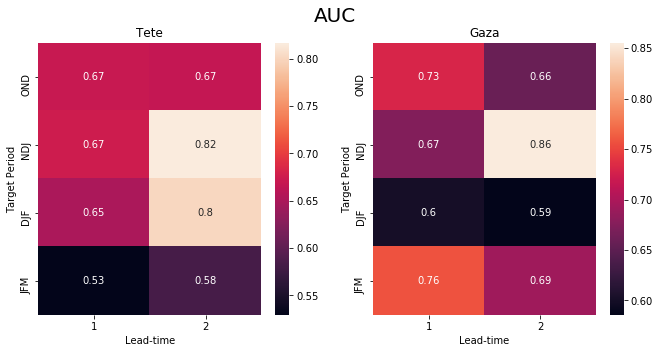

In [102]:
import seaborn as sns
import matplotlib.pylab as plt
  
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
a1 = sns.heatmap( auc_tete , xticklabels=lead_time, yticklabels=periods, ax = ax1, annot = True)
a1.set_title('Tete')
a1.set_xlabel('Lead-time')
a1.set_ylabel('Target Period')
a2 = sns.heatmap( auc_gaza , xticklabels=lead_time, yticklabels=periods, ax = ax2, annot = True)
a2.set_title('Gaza')
a2.set_xlabel('Lead-time')
a2.set_ylabel('Target Period')
fig.suptitle('AUC', size = 20)

In [ ]:
periods = ['OND', 'NDJ', 'DJF', 'JFM']
lead_time = [1, 2, 3, 4, 5, 6]

auc_tete = np.array([[auc_rg_tete_ond1, auc_rg_tete_ond2, auc_rg_tete_ond3, auc_rg_tete_ond4, auc_rg_tete_ond5, auc_rg_tete_ond6],
                     [auc_rg_tete_ndj1, auc_rg_tete_ndj2, auc_rg_tete_ndj3, auc_rg_tete_ndj4, auc_rg_tete_ndj5, auc_rg_tete_ndj6], 
                     [auc_rg_tete_djf1, auc_rg_tete_djf2, auc_rg_tete_djf3, auc_rg_tete_djf4, auc_rg_tete_djf5, auc_rg_tete_djf6], 
                     [auc_rg_tete_jfm1, auc_rg_tete_jfm2, auc_rg_tete_jfm3, auc_rg_tete_jfm4, auc_rg_tete_jfm5, auc_rg_tete_jfm6]])   # AUC's

auc_gaza = np.array([[auc_rg_gaza_ond1, auc_rg_gaza_ond2, auc_rg_gaza_ond3, auc_rg_gaza_ond4, auc_rg_gaza_ond5, auc_rg_gaza_ond6], 
                     [auc_rg_gaza_ndj1, auc_rg_gaza_ndj2, auc_rg_gaza_ndj3, auc_rg_gaza_ndj4, auc_rg_gaza_ndj5, auc_rg_gaza_ndj6],
                     [auc_rg_gaza_djf1, auc_rg_gaza_djf2, auc_rg_gaza_djf3, auc_rg_gaza_djf4, auc_rg_gaza_djf5, auc_rg_gaza_djf6], 
                     [auc_rg_gaza_jfm1, auc_rg_gaza_jfm2, auc_rg_gaza_jfm3, auc_rg_gaza_jfm4, auc_rg_gaza_jfm5, auc_rg_gaza_jfm6]])

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
a1 = sns.heatmap( auc_tete , xticklabels=lead_time, yticklabels=periods, ax = ax1, annot = True)
a1.set_title('Tete')
a1.set_xlabel('Lead-time')
a1.set_ylabel('Target Period')
a2 = sns.heatmap( auc_gaza , xticklabels=lead_time, yticklabels=periods, ax = ax2, annot = True)
a2.set_title('Gaza')
a2.set_xlabel('Lead-time')
a2.set_ylabel('Target Period')
fig.suptitle('AUC', size = 20)

## BSS test

In [94]:
periods = ['OND', 'NDJ', 'DJF', 'JFM']
lead_time = [1, 2]

bss_tete = np.array([[bss_rg_tete_ond1, bss_rg_tete_ond2], [bss_rg_tete_ndj1, bss_rg_tete_ndj2], 
                     [bss_rg_tete_djf1, bss_rg_tete_djf2], [bss_rg_tete_jfm1, bss_rg_tete_jfm2]])   # AUC's

bss_gaza = np.array([[bss_rg_gaza_ond1, bss_rg_gaza_ond2], [bss_rg_gaza_ndj1, bss_rg_gaza_ndj2],
                     [bss_rg_gaza_djf1, bss_rg_gaza_djf2], [bss_rg_gaza_jfm1, bss_rg_gaza_jfm2]])

Text(0.5,0.98,'BSS')

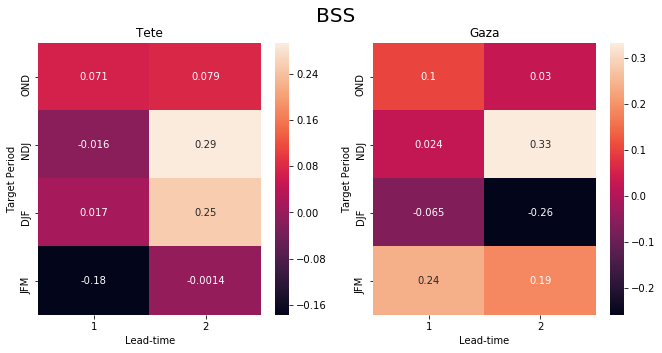

In [101]:
import seaborn as sns
import matplotlib.pylab as plt
  
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
a1 = sns.heatmap( bss_tete , xticklabels=lead_time, yticklabels=periods, ax = ax1, annot = True)
a1.set_title('Tete')
a1.set_xlabel('Lead-time')
a1.set_ylabel('Target Period')
a2 = sns.heatmap( bss_gaza , xticklabels=lead_time, yticklabels=periods, ax = ax2, annot = True)
a2.set_title('Gaza')
a2.set_xlabel('Lead-time')
a2.set_ylabel('Target Period')
fig.suptitle('BSS', size = 20)

In [ ]:
periods = ['OND', 'NDJ', 'DJF', 'JFM']
lead_time = [1, 2, 3, 4, 5, 6]

auc_tete = np.array([[bss_rg_tete_ond1, bss_rg_tete_ond2, bss_rg_tete_ond3, bss_rg_tete_ond4, bss_rg_tete_ond5, bss_rg_tete_ond6],
                     [bss_rg_tete_ndj1, bss_rg_tete_ndj2, bss_rg_tete_ndj3, bss_rg_tete_ndj4, bss_rg_tete_ndj5, bss_rg_tete_ndj6], 
                     [bss_rg_tete_djf1, bss_rg_tete_djf2, bss_rg_tete_djf3, bss_rg_tete_djf4, bss_rg_tete_djf5, bss_rg_tete_djf6], 
                     [bss_rg_tete_jfm1, bss_rg_tete_jfm2, bss_rg_tete_jfm3, bss_rg_tete_jfm4, bss_rg_tete_jfm5, bss_rg_tete_jfm6]])   # AUC's

auc_gaza = np.array([[bss_rg_gaza_ond1, bss_rg_gaza_ond2, bss_rg_gaza_ond3, bss_rg_gaza_ond4, bss_rg_gaza_ond5, bss_rg_gaza_ond6], 
                     [bss_rg_gaza_ndj1, bss_rg_gaza_ndj2, bss_rg_gaza_ndj3, bss_rg_gaza_ndj4, bss_rg_gaza_ndj5, bss_rg_gaza_ndj6],
                     [bss_rg_gaza_djf1, bss_rg_gaza_djf2, bss_rg_gaza_djf3, bss_rg_gaza_djf4, bss_rg_gaza_djf5, bss_rg_gaza_djf6], 
                     [bss_rg_gaza_jfm1, bss_rg_gaza_jfm2, bss_rg_gaza_jfm3, bss_rg_gaza_jfm4, bss_rg_gaza_jfm5, bss_rg_gaza_jfm6]])